In [1]:
import os,glob
import numpy as np
import pandas as pd
import glob
import fastjet
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob,os

pd.option_context('display.max_columns', -1)

pd.options.mode.chained_assignment = None #Disable copy warnings
# plt.style.use('fivethirtyeight') #Set style
# mpl.rcParams.update({'figure.figsize' : (15,10)})  #Set general plotting options
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({"savefig.dpi" : 300}) #Figure resolution


#Define plotting style:
sns.set() #Set style
sns.set_style('ticks',{'font.family':'Times New Roman', 'font.serif':'Times New Roman'})
sns.set_context('paper', font_scale=1.8)
cm = plt.cm.get_cmap('RdYlBu')

delphesDir = os.path.abspath("../../MG5/Delphes")
os.environ['ROOT_INCLUDE_PATH'] = os.path.join(delphesDir,"external")

import ROOT
import xml.etree.ElementTree as ET


ROOT.gSystem.Load(os.path.join(delphesDir,"libDelphes.so"))

ROOT.gInterpreter.Declare('#include "classes/SortableObject.h"')
ROOT.gInterpreter.Declare('#include "classes/DelphesClasses.h"')
ROOT.gInterpreter.Declare('#include "external/ExRootAnalysis/ExRootTreeReader.h"')

Welcome to JupyROOT 6.24/06


True

In [2]:
BR = 2*(0.6741*(0.1071+0.1063)) # Used to rescale the MG5 cross-section if the decay is included in the process
inputFile = list(glob.glob('../../processFolders/sm_ttdec_lo/Events/run_02/*_delphes_events.root'))[0]


In [ ]:
etamax=2.0
pTmin=355.0

atlas_bins = np.array([355.0,381.0,420.0,478.0,549.0,633.0,720.0,836.0,2000.0])
jetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 0.4)
fatjetdef = fastjet.JetDefinition(fastjet.antikt_algorithm, 1.0)

ntotal = 0
totalweightPBAll = np.zeros(350)
totalweightPB = 0.0
pTT = []
weights = []
cutFlow = {'n(l) = 1' : np.zeros(2), 
           'n(j) > 0' : np.zeros(2), 
           'n(FJ) > 0' : np.zeros(2), 
           'pT(FT) > %1.0f' %pTmin : np.zeros(2), 
           'eta(FT) < %1.1f' %etamax : np.zeros(2), 
           'b-jet in FT' : np.zeros(2),  
           'pT(lep) > 27' : np.zeros(2), 
           'eta(lep) < 2.5' : np.zeros(2), 
           'dR(lepton,b) < 2.0' : np.zeros(2), 
           'm(lepton,b) < 180' : np.zeros(2), 
           'dR(lepton,j) > 0.4' : np.zeros(2),
           'MET > 20' : np.zeros(2)}

In [3]:
f = ROOT.TFile(inputFile,'read')
tree = f.Get("Delphes")
nevts = tree.GetEntries()

for ievt in range(nevts):    
    error = False
    ntotal += 1
    tree.GetEntry(ievt)
    weightPB = tree.Weight.At(1).Weight
    weightAndError = np.array([weightPB,weightPB**2])
    totalweightPB += weightPB
    for ii in range(tree.Weight.GetEntries()):
        totalweightPBAll[ii] += tree.Weight.At(ii).Weight
    # continue

    genParticles = tree.Particle
    # Filter tops:
    tops = {}
    for iptc in range(genParticles.GetEntries()):
        ptc = genParticles.At(iptc)
        if abs(ptc.PID) == 6:
            tops[ptc.PID] = ptc # Store only the last top/anti-top

    # Get top and W decays:
    topDecays = {}
    for itop,top in tops.items():
        topDecays[top.PID] = []
        for idaugther in range(top.D1,top.D2+1):
            ptc = genParticles.At(idaugther)
            if abs(ptc.PID) == 5:
                topDecays[top.PID].append(ptc)
            elif abs(ptc.PID) == 24:
                w = ptc
                d1 = w.D1
                d2 = w.D2+1
                daughter1 = genParticles.At(d1)
                while daughter1.PID == w.PID:
                    d1 = daughter1.D1
                    d2 = daughter1.D2+1
                    daughter1 = genParticles.At(d1)
                for idaugther2 in range(d1,d2):
                    ptcD = genParticles.At(idaugther2)
                    topDecays[top.PID].append(ptcD)
            elif abs(ptc.PID) == 6:
                print('Error getting top decays')
                error = True
                break
    if error:
        break
    
    # Select events with one lepton and one hadronic top:
    topH = None
    topLep = None
    for topPID,daughters in topDecays.items():
            dPIDs =  [abs(ptc.PID) for ptc in daughters]
            if not 5 in dPIDs:
                continue # Skip rare decays to W+c
            if (11 in dPIDs) or (13 in dPIDs):
                topLep = topPID
            elif max(dPIDs) <= 5:
                topH = topPID

    
    if topH is None or topLep is None:
        continue
   
    cutFlow['n(l) = 1'] += weightAndError

    # Hadronic top:    
    # Regular jets:
    quarks = [ptc for ptc in topDecays[topH]]
    jetArray = [fastjet.PseudoJet(q.Px,q.Py,q.Pz,q.E) for q in quarks if abs(q.Eta) < 4.5]
    for ij,j in enumerate(jetArray):
        j.set_user_index(quarks[ij].PID)
    cluster = fastjet.ClusterSequence(jetArray, jetdef)
    jets = cluster.inclusive_jets(ptmin = 26.0)
    jets = [j for j in jets if abs(j.eta()) < 2.5]
    if len(jets) == 0:
        continue
    cutFlow['n(j) > 0'] += weightAndError

        
    # ## Fat jet:    
    jetArray = [fastjet.PseudoJet(j.px(),j.py(),j.pz(),j.E()) for j in jets]
    for ij,j in enumerate(jetArray):
        for q in jets[ij].constituents():
            if abs(q.user_index()) == 5:
                j.set_user_index(5) # Tag the regular jets containing a b-quark
    clusterFat = fastjet.ClusterSequence(jetArray, fatjetdef)
    if len(clusterFat.inclusive_jets()) == 0:
        continue
    cutFlow['n(FJ) > 0'] += weightAndError

    # Use hardest fat jet
    fatJet = sorted([j for j in clusterFat.inclusive_jets()], key = lambda j: j.pt(), reverse=True)[0]
    # Invariant mass cut:
    if not (120. < fatJet.m() < 220.):
        continue
    # PT cut
    if fatJet.pt() < pTmin:
        continue
    cutFlow['pT(FT) > %1.0f' %pTmin] += weightAndError

    # Eta cut
    if abs(fatJet.eta()) > etamax:
        continue
    cutFlow['eta(FT) < %1.1f' %etamax] += weightAndError

    # Require a b inside the Fat jet
    hasB = False
    for q in fatJet.constituents():
        if q.user_index() == 5:
            hasB = True
    if not hasB:
        continue
    cutFlow['b-jet in FT'] += weightAndError

        
    # Leptonic top:
    leptons = [ptc for ptc in topDecays[topLep] if abs(ptc.PID) in [11,13]]
    neutrinos = [ptc for ptc in topDecays[topLep] if abs(ptc.PID) in [12,14]]
    bLep = [ptc for ptc in topDecays[topLep] if abs(ptc.PID) ==5]
    if len(leptons) != 1:
        error = True
        print('Error getting leptons')
    if len(neutrinos) != 1:
        error = True
        print('Error getting neutrinos')
    if len(bLep) != 1:
        error = True
        print('Error getting b-jet')
        break
    if error:
        break
    lepton = leptons[0]
    nu = neutrinos[0]
    bLep = bLep[0]
    
    pTlepton = lepton.PT
    etaLep = np.abs(lepton.Eta)
    # Lepton pT cut
    if pTlepton < 27.0:
        continue
    cutFlow['pT(lep) > 27'] += weightAndError

    # Lepton eta cut
    if etaLep > 2.5:
        continue
    cutFlow['eta(lep) < 2.5'] += weightAndError

    # Require the b to be close to the lep'MET > 20'ton
    dRlep = np.sqrt((lepton.Eta-bLep.Eta)**2 + (lepton.Phi-bLep.Phi)**2)
    if dRlep > 2.0:
        continue
    cutFlow['dR(lepton,b) < 2.0'] += weightAndError

    # Invariant mass of lepton and b < 180:
    mlb = np.sqrt((lepton.E+bLep.E)**2-(lepton.Px+bLep.Px)**2-(lepton.Py+bLep.Py)**2-(lepton.Pz+bLep.Pz)**2)
    if mlb > 180.0:
        continue
    cutFlow['m(lepton,b) < 180'] += weightAndError

    # Skip events where lepton overlaps to jet
    dRlep = min([np.sqrt((lepton.Eta-j.eta())**2 + (lepton.Phi-j.phi())**2) for j in jets])    
    if dRlep < 0.4:
        continue
    cutFlow['dR(lepton,j) > 0.4'] += weightAndError

    # MET cut
    if (nu.PT < 20.0):
        continue
    cutFlow['MET > 20'] += weightAndError

    pTT.append(tops[topH].PT)
    weights.append(weightAndError)
    

f.Close()
weights = np.array(weights)
pTtHist,_ = np.histogram(pTT,weights=weights[:,0],bins=atlas_bins)
pTtHistError,_ = np.histogram(pTT,weights=weights[:,1],bins=atlas_bins)
pTtHistError = np.sqrt(pTtHistError)
for val in cutFlow.values():
    val[1] = np.sqrt(val[1])

data = np.array(list(zip(atlas_bins[:-1],atlas_bins[1:],pTtHist,pTtHistError)))
    

#--------------------------------------------------------------------------
#                         FastJet release 3.4.1
#                 M. Cacciari, G.P. Salam and G. Soyez                  
#     A software package for jet finding and analysis at colliders      
#                           http://fastjet.fr                           
#	                                                                      
# Please cite EPJC72(2012)1896 [arXiv:1111.6097] if you use this package
# for scientific work and optionally PLB641(2006)57 [hep-ph/0512210].   
#                                                                       
# FastJet is provided without warranty under the GNU GPL v2 or higher.  
# It uses T. Chan's closest pair algorithm, S. Fortune's Voronoi code,
# CGAL and 3rd party plugin jet algorithms. See COPYING file for details.
#--------------------------------------------------------------------------


In [11]:
# Inclusive cross-section (total ttbar production)
inclusiveXsec = totalweightPB/BR
# Compute k-factor based on the inclusive production cross-section:
kfac = 832./inclusiveXsec

print('xsec (pb) = %1.3e' %(inclusiveXsec))
print('fiducial xsec*kfac (pb) = %1.3e' %(sum(weights[:,0])*kfac))


xsec (pb) = 4.606e+02
fiducial xsec*kfac (pb) = 1.429e+00


In [13]:
xsec_before = totalweightPB
for c,xsec in cutFlow.items():
    print('%s : %1.2f +- %1.0g (%1.2f%%)' %(c,xsec[0]*kfac,xsec[1]*kfac,100*xsec[0]/xsec_before))
    xsec_before = xsec[0]

n(l) = 1 : 237.25 +- 0.8 (99.11%)
n(j) > 0 : 234.00 +- 0.7 (98.63%)
n(FJ) > 0 : 234.00 +- 0.7 (100.00%)
pT(FT) > 355 : 2.32 +- 0.07 (0.99%)
eta(FT) < 2.0 : 2.26 +- 0.07 (97.52%)
b-jet in FT : 2.26 +- 0.07 (100.00%)
pT(lep) > 27 : 1.90 +- 0.07 (83.81%)
eta(lep) < 2.5 : 1.88 +- 0.07 (99.24%)
dR(lepton,b) < 2.0 : 1.58 +- 0.06 (83.84%)
m(lepton,b) < 180 : 1.58 +- 0.06 (100.00%)
dR(lepton,j) > 0.4 : 1.58 +- 0.06 (100.00%)
MET > 20 : 1.43 +- 0.06 (90.59%)


In [16]:
sm_nnlo = np.loadtxt('./digitised_sm/nnlo_from_fig11.txt',dtype=float,usecols=(0,))
bins_width = atlas_bins[1:]-atlas_bins[:-1]

In [19]:
for ibin,pt in enumerate(data):
    r = pt[2]*kfac/(sm_nnlo[ibin]*bins_width[ibin])
    rErr = pt[3]*kfac/(sm_nnlo[ibin]*bins_width[ibin])
    print('Bin: %1.0f--%1.0f' %(pt[0],pt[1]))
    print("MG5 = %1.2e, ATLAS = %1.2e (ratio = %1.2f +- %1.1f)\n" %(pt[2]*kfac,sm_nnlo[ibin]*bins_width[ibin],r,rErr))

Bin: 355--381
MG5 = 2.20e-01, ATLAS = 3.04e-01 (ratio = 0.73 +- 0.1)

Bin: 381--420
MG5 = 3.42e-01, ATLAS = 3.44e-01 (ratio = 0.99 +- 0.1)

Bin: 420--478
MG5 = 3.57e-01, ATLAS = 3.18e-01 (ratio = 1.12 +- 0.1)

Bin: 478--549
MG5 = 2.54e-01, ATLAS = 1.97e-01 (ratio = 1.29 +- 0.1)

Bin: 549--633
MG5 = 1.53e-01, ATLAS = 1.02e-01 (ratio = 1.51 +- 0.2)

Bin: 633--720
MG5 = 5.99e-02, ATLAS = 4.13e-02 (ratio = 1.45 +- 0.3)

Bin: 720--836
MG5 = 3.11e-02, ATLAS = 1.95e-02 (ratio = 1.60 +- 0.4)

Bin: 836--2000
MG5 = 1.20e-02, ATLAS = 9.53e-03 (ratio = 1.26 +- 0.6)



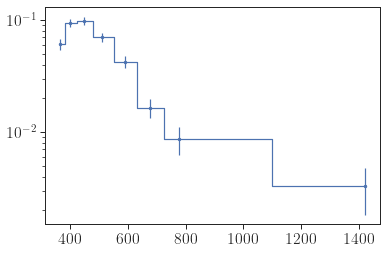

In [20]:
plt.hist(pTT,weights=weights[:,0],bins=atlas_bins,histtype='step')
plt.errorbar((atlas_bins[:-1]+atlas_bins[1:])/2, pTtHist, yerr=pTtHistError,marker = '.', drawstyle = 'steps-mid')
plt.yscale('log')
# plt.xlim(500.,1500.)
# plt.ylim(1e-3,1e-1)
plt.show()